<a href="https://colab.research.google.com/github/kim-kidong/hello-world/blob/master/0919_%E1%84%8C%E1%85%A5%E1%86%AB%E1%84%85%E1%85%A7%E1%86%A8%E1%84%83%E1%85%A6%E1%84%8B%E1%85%B5%E1%84%90%E1%85%A5%E1%84%87%E1%85%AE%E1%86%AB%E1%84%89%E1%85%A5%E1%86%A8_Conv1D_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
# import coremltools
from scipy import stats
from IPython.display import display, HTML
import os
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
from IPython.display import Image

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
%config InlineBackend.figure_format = 'retina'#맥북 화질 깨끗하게 나오는 코드

In [0]:
energy = pd.read_csv(os.path.join('data', 'energy_3years.csv'), parse_dates=['timestamp']) 
energy.head()

,timestamp,load,temp
0,2012-01-01 00:00:00,2698.0,32.000000
1,2012-01-01 01:00:00,2558.0,32.666667
2,2012-01-01 02:00:00,2444.0,30.000000
3,2012-01-01 03:00:00,2402.0,31.000000
4,2012-01-01 04:00:00,2403.0,32.000000


In [0]:
energy.index = energy['timestamp']
energy = energy.reindex(pd.date_range(min(energy['timestamp']),
                max(energy['timestamp']), freq='H'))
energy = energy.drop('timestamp', axis=1)[['load']]
energy.head()

,load
2012-01-01 00:00:00,2698.0
2012-01-01 01:00:00,2558.0
2012-01-01 02:00:00,2444.0
2012-01-01 03:00:00,2402.0
2012-01-01 04:00:00,2403.0


In [0]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

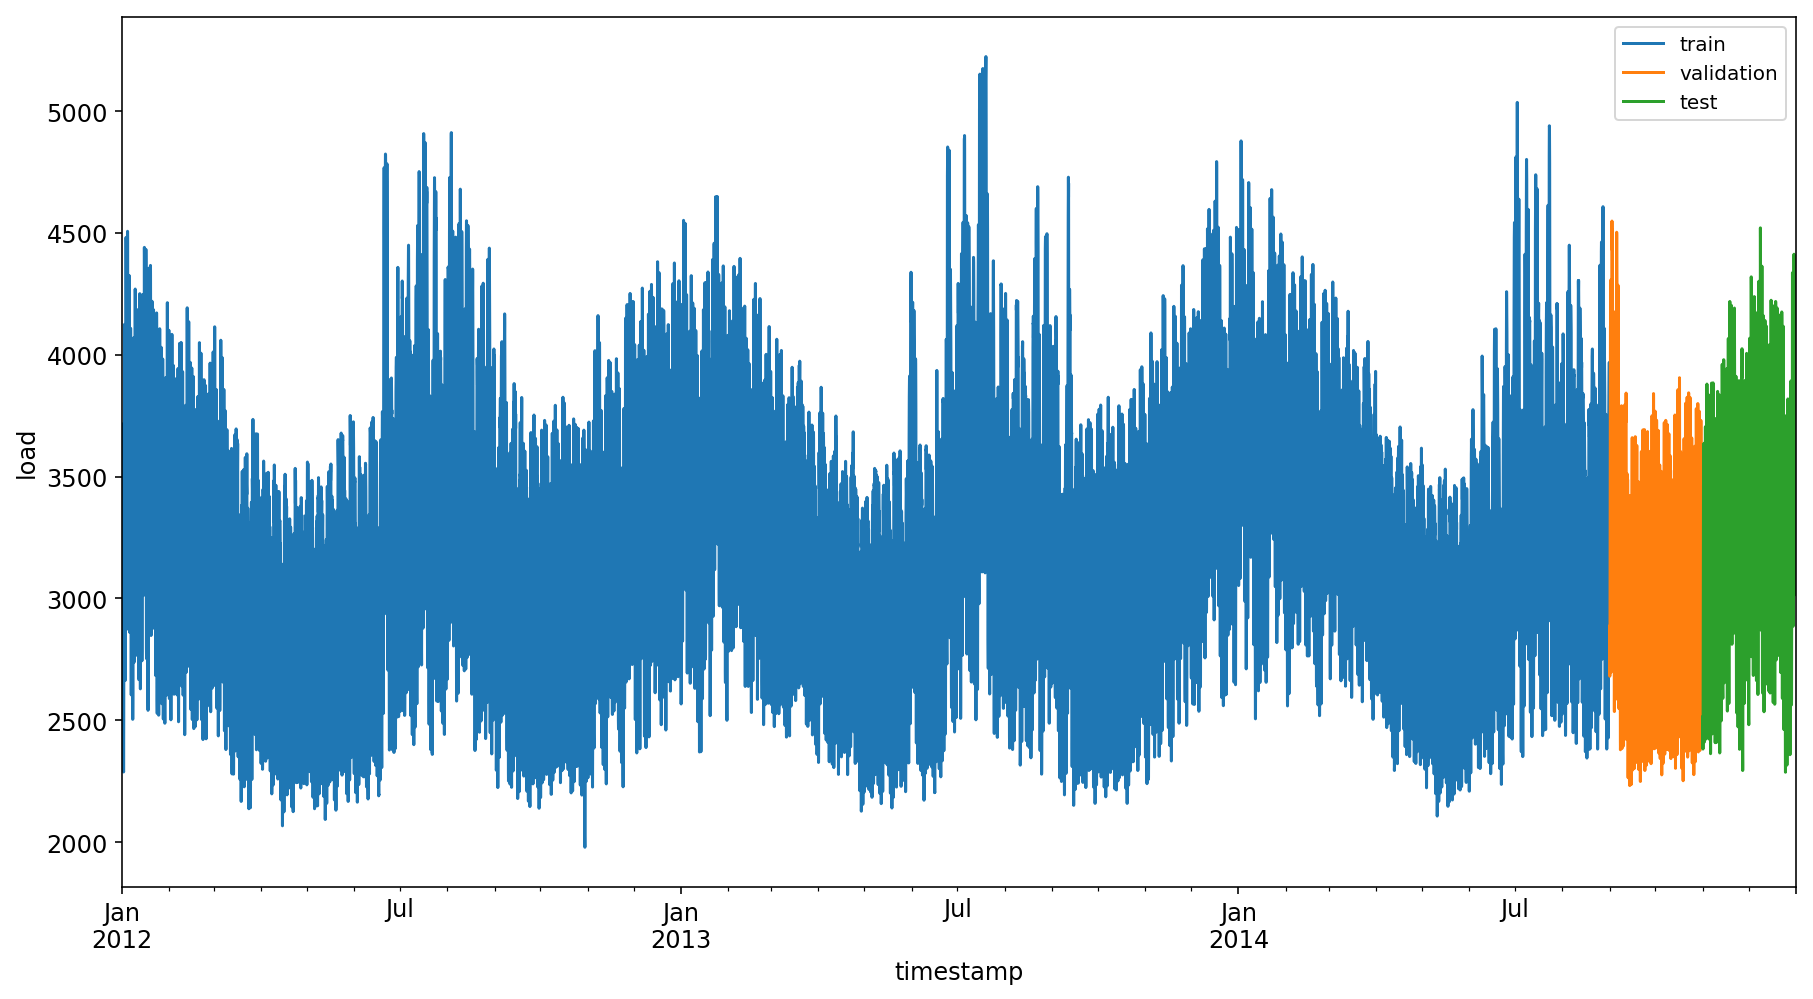

In [0]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'train'}) \
    .join(energy[(energy.index >=valid_start_dt) & (energy.index < test_start_dt)][['load']] \
          .rename(columns={'load':'validation'}), how='outer') \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [0]:
T = 11
HORIZON = 1

In [0]:
# 1. Get the train data from the correct data range
train = energy.copy()[energy.index < valid_start_dt][['load']]

# 2. Scale data to be in range (0, 1). 
#   This transformation should be calibrated on the training set only. 
#   This is to prevent information from the validation or test sets 
#   leaking into the training data.
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)

# 3. Shift the dataframe to create the input samples.
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    train_shifted[str(T-t)] = train_shifted['load'].shift(T-t, freq='H')
y_col = 'y_t+1'
X_cols = ['load_t-10','load_t-9','load_t-8','load_t-7','load_t-6','load_t-5',
             'load_t-4',
             'load_t-3',
             'load_t-2',
             'load_t-1',
             'load_t']
train_shifted.columns = ['load_original']+[y_col]+X_cols

# 4.Discard any samples with missing values
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,load_original,y_t+1,load_t-10,load_t-9,load_t-8,load_t-7,load_t-6,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 10:00:00,0.368259,0.370108,0.221572,0.178428,0.143297,0.130354,0.130663,0.146071,0.179045,0.228043,0.288752,0.346995,0.368259
2012-01-01 11:00:00,0.370108,0.371341,0.178428,0.143297,0.130354,0.130663,0.146071,0.179045,0.228043,0.288752,0.346995,0.368259,0.370108
2012-01-01 12:00:00,0.371341,0.359938,0.143297,0.130354,0.130663,0.146071,0.179045,0.228043,0.288752,0.346995,0.368259,0.370108,0.371341
2012-01-01 13:00:00,0.359938,0.352234,0.130354,0.130663,0.146071,0.179045,0.228043,0.288752,0.346995,0.368259,0.370108,0.371341,0.359938
2012-01-01 14:00:00,0.352234,0.356857,0.130663,0.146071,0.179045,0.228043,0.288752,0.346995,0.368259,0.370108,0.371341,0.359938,0.352234


In [0]:
# 5.Transform this Pandas dataframe into a numpy array
y_train = train_shifted[y_col].as_matrix()
X_train = train_shifted[X_cols].as_matrix()

In [0]:
# This is an important step to reshape the X into 3 dimension array
X_train = X_train.reshape(X_train.shape[0], T, 1)
X_train[:3]

array([[[0.22157165],
        [0.17842835],
        [0.14329738],
        [0.13035439],
        [0.13066256],
        [0.14607088],
        [0.17904468],
        [0.22804314],
        [0.28875193],
        [0.34699538],
        [0.36825886]],

       [[0.17842835],
        [0.14329738],
        [0.13035439],
        [0.13066256],
        [0.14607088],
        [0.17904468],
        [0.22804314],
        [0.28875193],
        [0.34699538],
        [0.36825886],
        [0.37010786]],

       [[0.14329738],
        [0.13035439],
        [0.13066256],
        [0.14607088],
        [0.17904468],
        [0.22804314],
        [0.28875193],
        [0.34699538],
        [0.36825886],
        [0.37010786],
        [0.37134052]]])

In [0]:
# 1. Get the validation data from the correct data range
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load']]

# 2. Scale the series using the transformer fitted on the training set:
valid['load'] = scaler.transform(valid)

# 3. Shift the dataframe to create the input samples
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    valid_shifted['load_t-'+str(T-t)] = valid_shifted['load'].shift(T-t, freq='H')
    
# 4.Discard any samples with missing values
valid_shifted = valid_shifted.dropna(how='any')
valid_shifted.head(3)

,load,y+1,load_t-10,load_t-9,load_t-8,load_t-7,load_t-6,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
2014-09-01 00:00:00,0.279507,0.243143,0.556857,0.565177,0.579353,0.603082,0.609553,0.613251,0.582435,0.512789,0.427119,0.344530,0.279507
2014-09-01 01:00:00,0.243143,0.221880,0.565177,0.579353,0.603082,0.609553,0.613251,0.582435,0.512789,0.427119,0.344530,0.279507,0.243143
2014-09-01 02:00:00,0.221880,0.216333,0.579353,0.603082,0.609553,0.613251,0.582435,0.512789,0.427119,0.344530,0.279507,0.243143,0.221880


In [0]:
# 5.Transform this Pandas dataframe into a numpy array
y_valid = valid_shifted['y+1'].as_matrix()
X_valid = valid_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].as_matrix()
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

In [0]:
X_train.shape

(23365, 11, 1)

In [0]:
model_m = Sequential()
# 커널이 100개 1차원필터사이즈 10
model_m.add(Conv1D(100, 3, activation='relu', input_shape=(T,1), padding='same'))
model_m.add(Conv1D(100, 3, activation='relu', padding='same'))

model_m.add(MaxPooling1D(3))#1차원에서 3개중 1개씩 뽑아냄
model_m.add(Conv1D(256, 3, activation='relu', padding='same'))
model_m.add(Conv1D(256, 3, activation='relu', padding='same'))

model_m.add(GlobalAveragePooling1D())# ??
model_m.add(Dropout(0.5))
# model_m.add(Dense(128, activation='relu')) # 더 떨어짐
model_m.add(Dense(1))
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_51 (Conv1D)           (None, 11, 100)           400       
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 11, 100)           30100     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 3, 100)            0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 3, 256)            77056     
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 3, 256)            196864    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
__________

In [0]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='modelSave/best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='loss', patience=1)
]

model_m.compile(loss='mean_squared_error',optimizer='adam')

BATCH_SIZE = 400
EPOCHS = 50

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 18692 samples, validate on 4673 samples
Epoch 1/50
18692/18692 [==============================] - 5s 254us/step - loss: 0.0308 - val_loss: 0.0062
Epoch 2/50
18692/18692 [==============================] - 4s 232us/step - loss: 0.0048 - val_loss: 0.0034
Epoch 3/50
18692/18692 [==============================] - 5s 253us/step - loss: 0.0024 - val_loss: 0.0010
Epoch 4/50
18692/18692 [==============================] - 5s 258us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 5/50
18692/18692 [==============================] - 5s 262us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 6/50
18692/18692 [==============================] - 5s 269us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 7/50
18692/18692 [==============================] - 5s 275us/step - loss: 0.0013 - val_loss: 8.8570e-04
Epoch 8/50
18692/18692 [==============================] - 5s 255us/step - loss: 0.0012 - val_loss: 7.2019e-04
Epoch 9/50
18692/18692 [==============================] - 5s 262us/step - loss: 0.0010 - val_lo

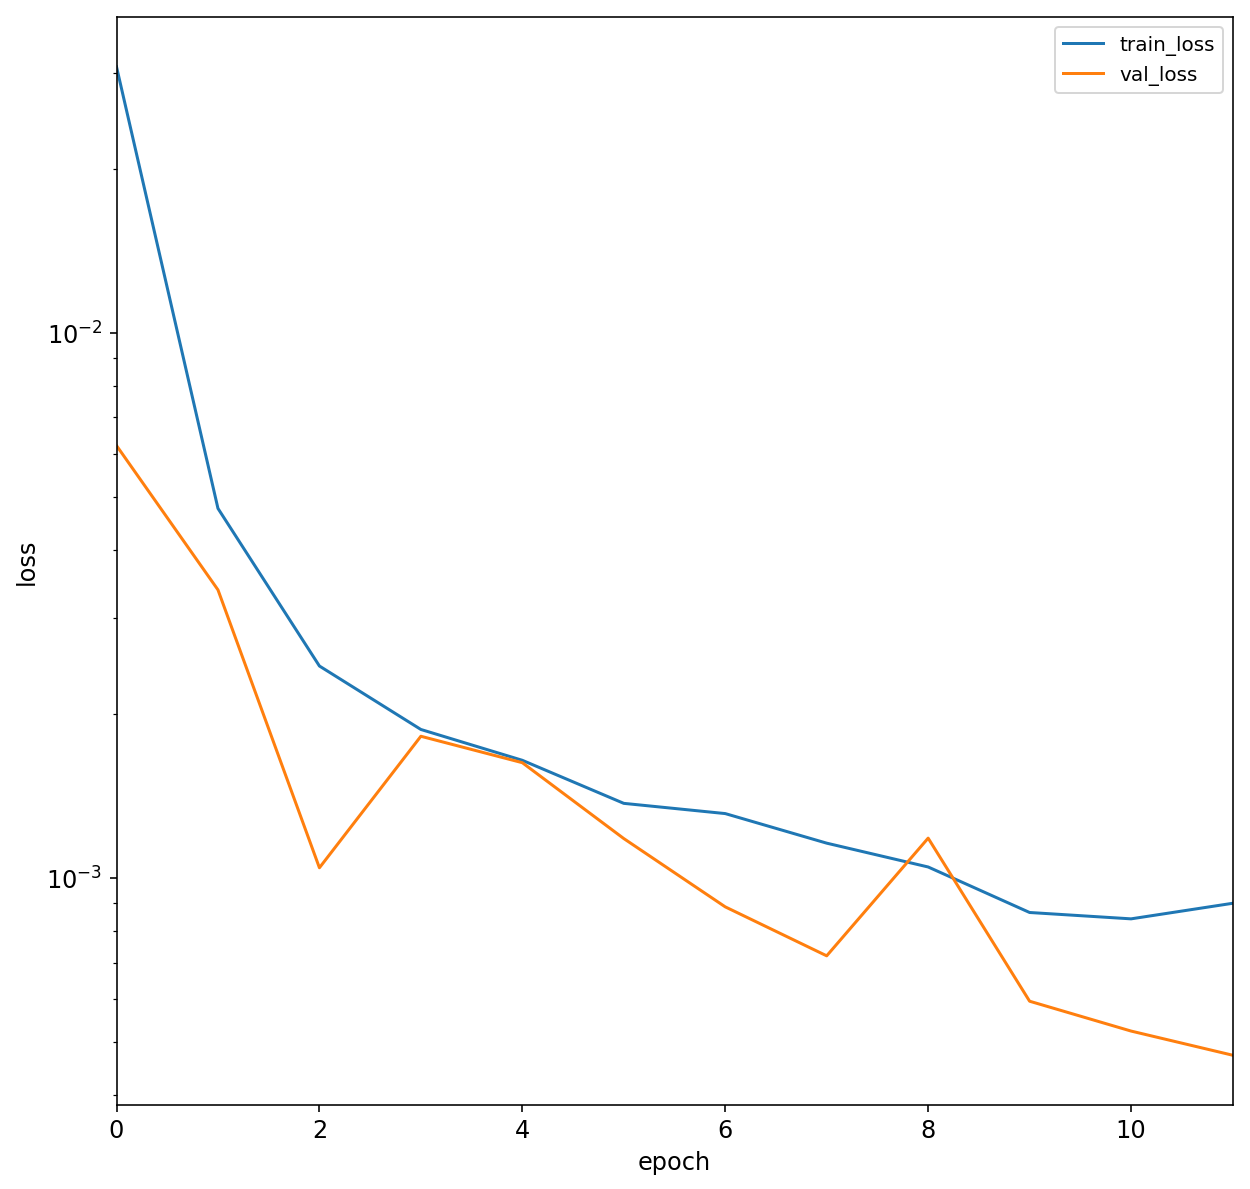

In [0]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [0]:
# 1. Get the test data from the correct data range
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load']]

# 2. Scale the data
test['load'] = scaler.transform(test)

# 3. Shift the dataframe to create the input samples
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    test_shifted['load_t-'+str(T-t)] = test_shifted['load'].shift(T-t, freq='H')

# 4.Discard any samples with missing values
test_shifted = test_shifted.dropna(how='any')

# 5.Transform this Pandas dataframe into a numpy array
y_test = test_shifted['y_t+1'].as_matrix()
X_test = test_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].as_matrix()
X_test = X_test.reshape(X_test.shape[0], T, 1)


In [0]:
predictions = model_m.predict(X_test)
predictions

array([[0.45571637],
       [0.45420927],
       [0.45036903],
       ...,
       [0.46655834],
       [0.42901382],
       [0.39777175]], dtype=float32)

In [0]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 10:00:00,t+1,3457.799626,3464.0
1,2014-11-01 11:00:00,t+1,3452.909075,3439.0
2,2014-11-01 12:00:00,t+1,3440.447503,3407.0
3,2014-11-01 13:00:00,t+1,3399.126557,3389.0
4,2014-11-01 14:00:00,t+1,3393.854878,3402.0


In [0]:
# %load -s mape common/utils.py
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

In [0]:
mape(eval_df['prediction'], eval_df['actual'])

0.014098938928641482

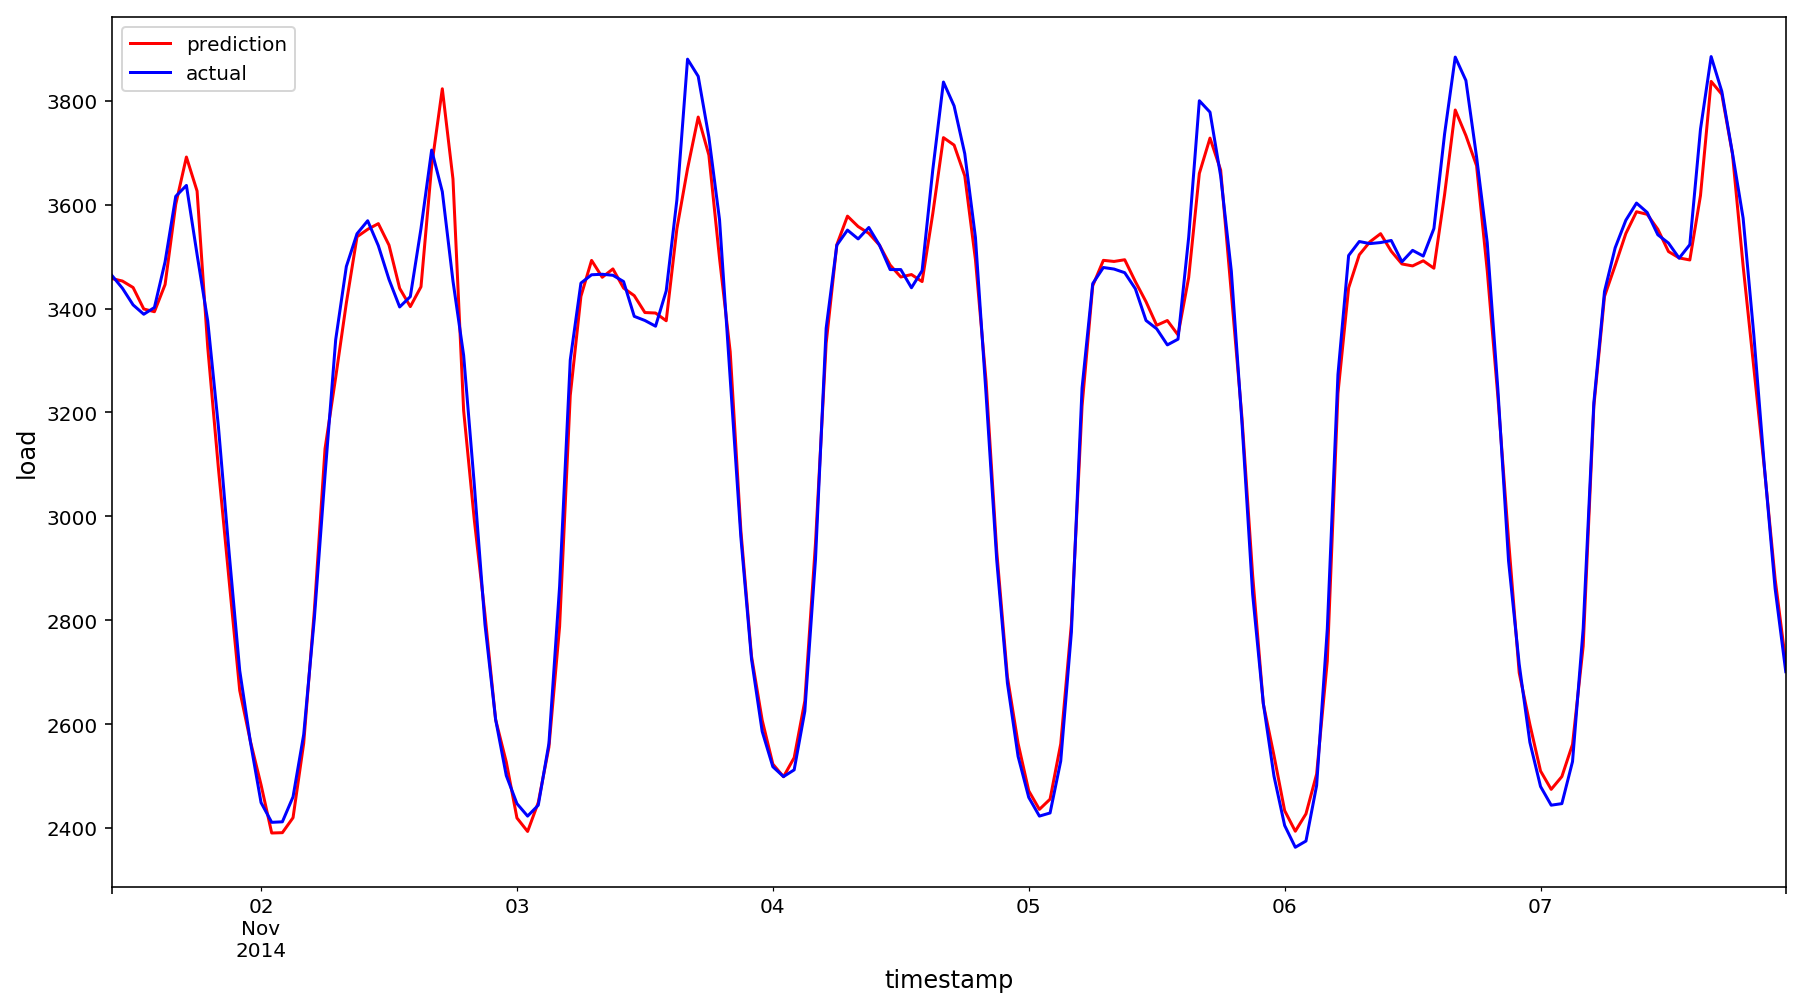

In [0]:
eval_df[eval_df.timestamp<'2014-11-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

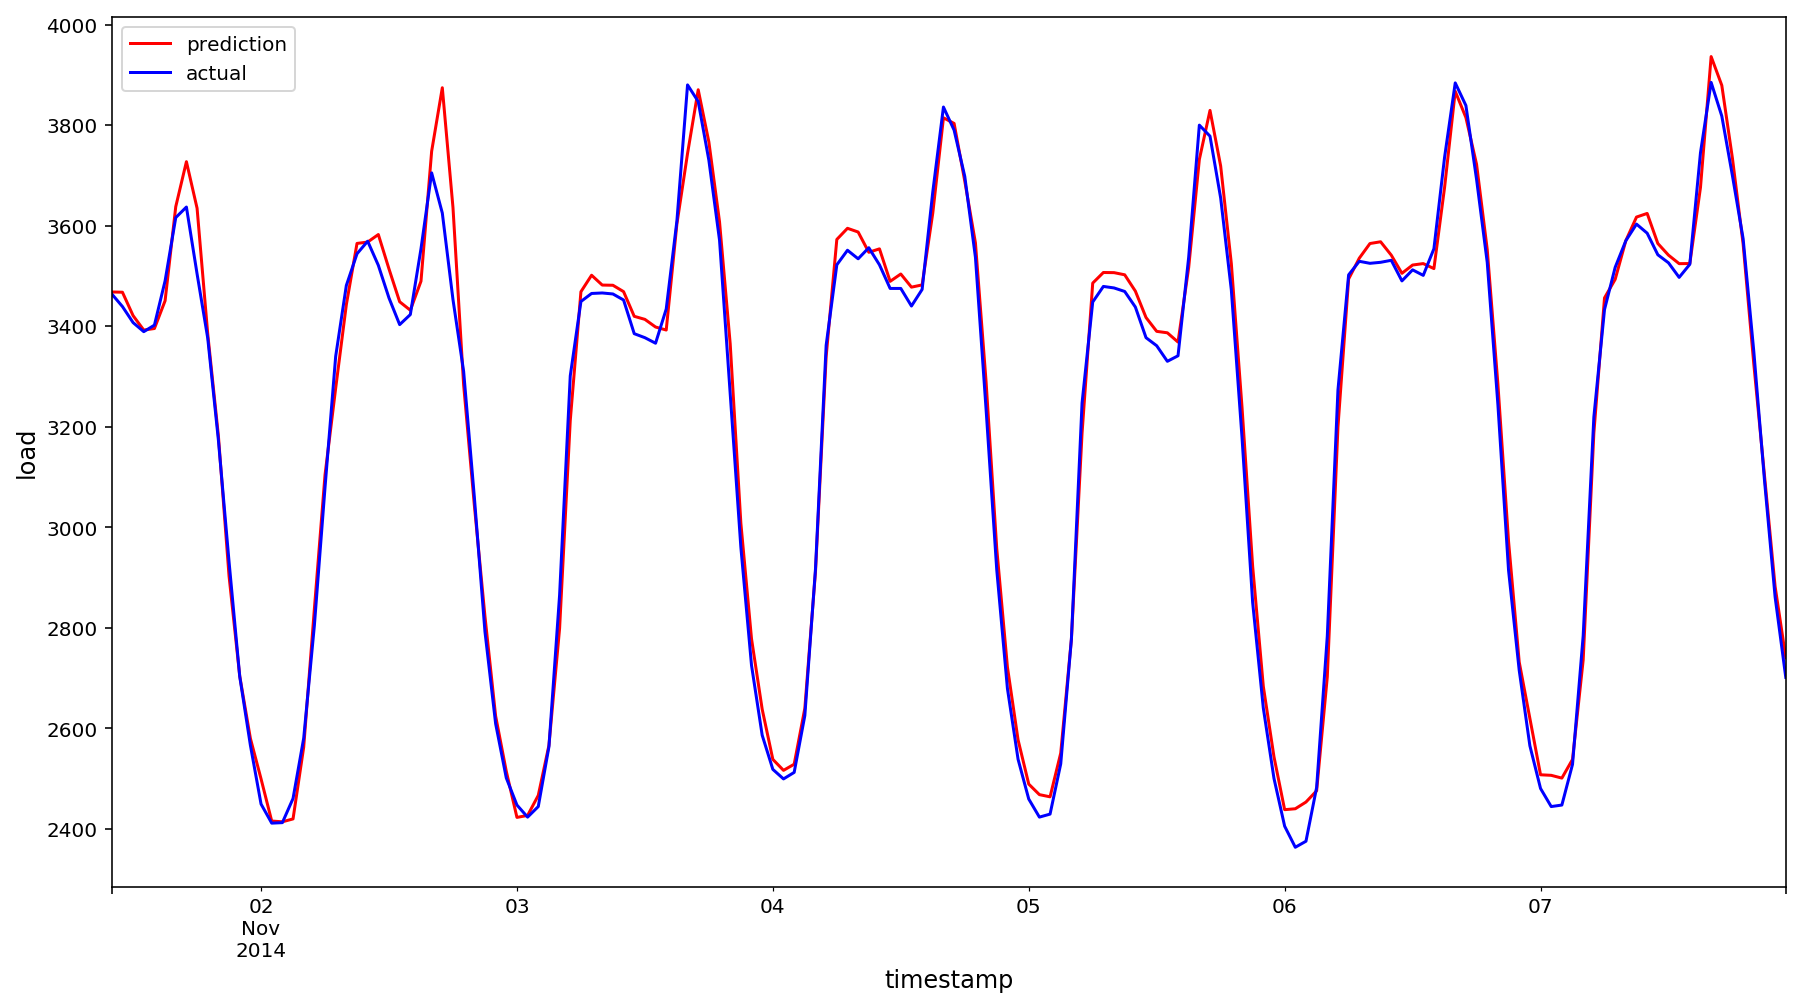

In [0]:
eval_df[eval_df.timestamp<'2014-11-08'].plot(x='timestamp', y=['prediction', 'actual'], style=['r', 'b'], figsize=(15, 8))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()